In [10]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from torchvision import models, transforms
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask

In [11]:
class_map = {
    "No finding": 0,
    "Cardiomegaly": 1,
    "Nodule/Mass": 2,
    "Lung Opacity": 3,
    "Pleural effusion": 4,
    "Consolidation": 5
}

inv_class_map = {v: k for k, v in class_map.items()}
df = pd.read_csv("vinbigdata_labeled.csv")

In [12]:
# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

class XRayDataset(Dataset):
    def __init__(self, image_folder, csv_file):
        self.image_folder = image_folder
        self.df = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row["image_id"] + ".jpg")
        image = Image.open(img_path)
        image = transform(image)
        label = torch.tensor(row["label"], dtype=torch.long)
        return image, label

In [13]:

dataset = XRayDataset("vinbigdata_resized", "vinbigdata_labeled.csv")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:
def build_resnet_model(num_classes=6):
    model = models.resnet18(pretrained=True)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    return model

model_list = []
for i in range(3):
    model = build_resnet_model()
    model.load_state_dict(torch.load(f"vin_model_{i+1}.pth"))
    model.to(device)
    model.eval()
    model_list.append(model)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [54]:
img, label = dataset[0]  # 0 for image index in dataset, just for exap,le
input_tensor = img.unsqueeze(0).to(device)

cam_model = build_resnet_model()
cam_model.load_state_dict(torch.load("vin_model_1.pth"))
cam_model.to(device)
cam_model.eval()

cam_extractor = GradCAM(cam_model, target_layer="layer4")
scores = cam_model(input_tensor)
pred_class = scores.argmax().item()
activation_map = cam_extractor(class_idx=pred_class, scores=scores)

In [47]:
# # image that is label 1
# temp_img, temp_label = dataset[1]

# print(temp_label)

tensor(1)


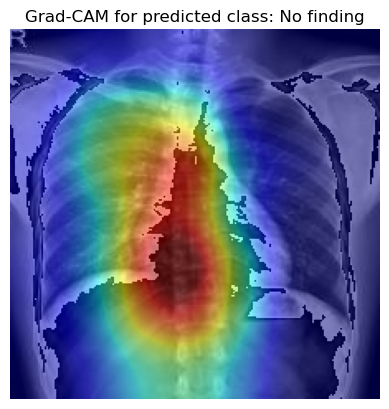

In [55]:
heatmap = activation_map[0].squeeze(0)
overlay = overlay_mask(to_pil_image(img), to_pil_image(heatmap, mode='F'), alpha=0.5)

plt.imshow(overlay)
plt.title(f"Grad-CAM for predicted class: {inv_class_map[pred_class]}")
plt.axis('off')
plt.show()

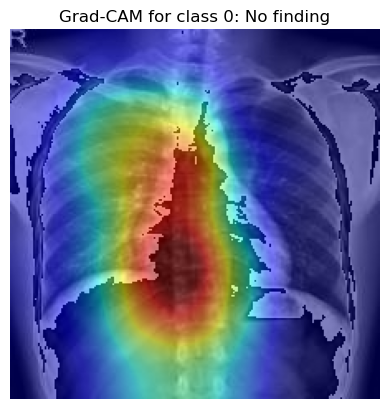

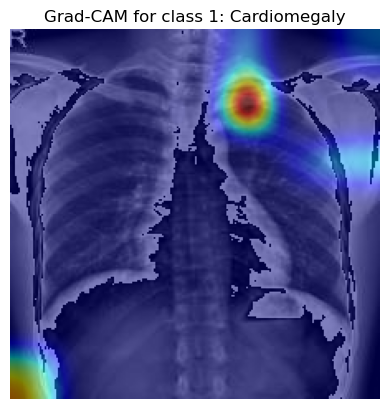

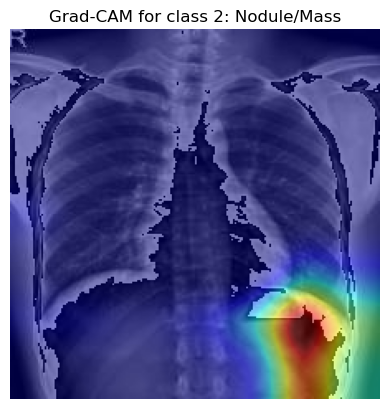

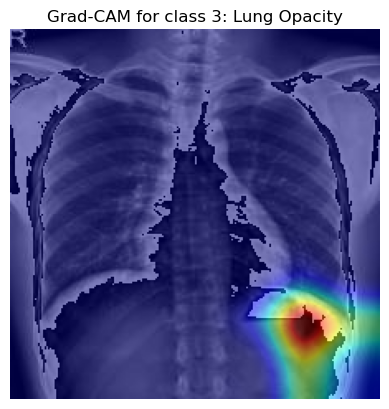

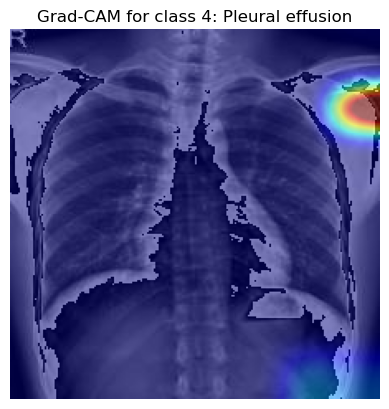

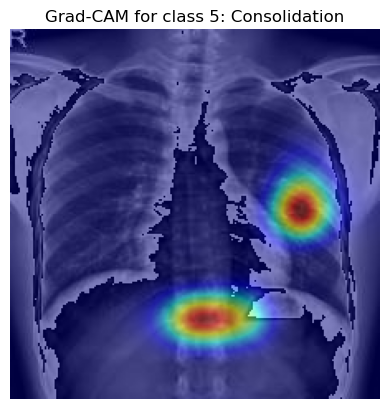

In [56]:
for class_idx in range(6):
    scores = cam_model(input_tensor)
    activation_map = cam_extractor(class_idx=class_idx, scores=scores)
    heatmap = activation_map[0].squeeze(0)
    overlay = overlay_mask(to_pil_image(img), to_pil_image(heatmap, mode='F'), alpha=0.5)

    plt.imshow(overlay)
    plt.title(f"Grad-CAM for class {class_idx}: {inv_class_map[class_idx]}")
    plt.axis('off')
    plt.show()


**Grad-CAM for OOD data**

In [22]:
chexpert_dataset = XRayDataset("chexpert_resized", "chexpert_subset.csv")

In [60]:
# OOD sample from Chexpert dataset
ood_img, ood_label = chexpert_dataset[0]
input_tensor = ood_img.unsqueeze(0).to(device)

In [57]:
# # example of a sample from the Chexpert dataset that isn't no finding

# exampleimage, examplelabel = chexpert_dataset[2]
# print(examplelabel)


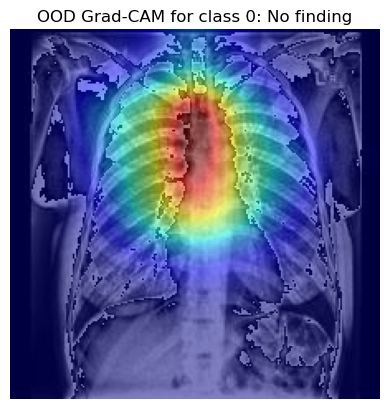

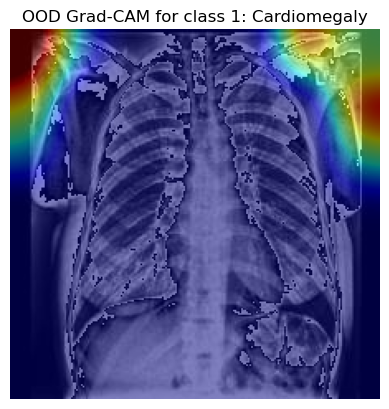

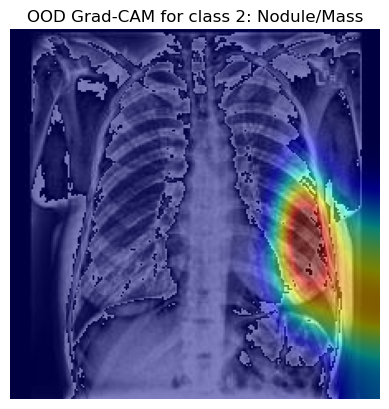

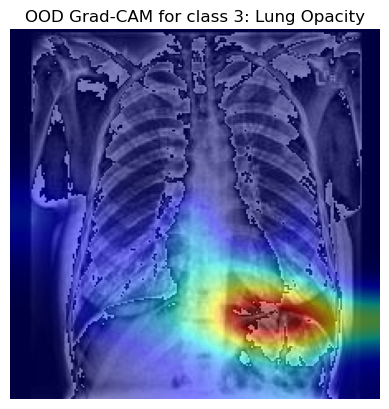

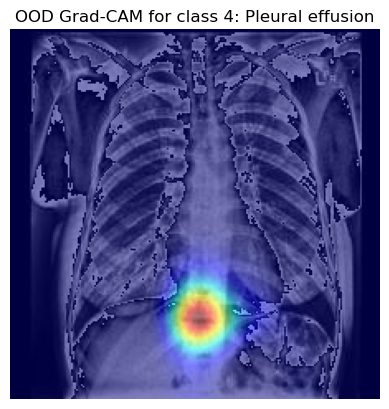

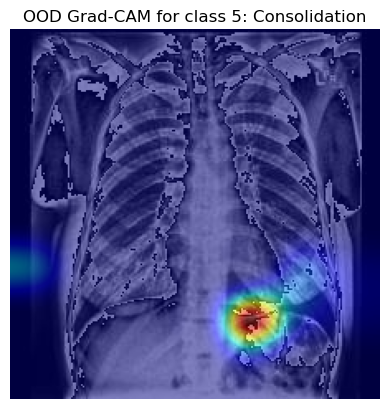

In [61]:

for class_idx in range(6):
    scores = cam_model(input_tensor)
    activation_map = cam_extractor(class_idx=class_idx, scores=scores)
    heatmap = activation_map[0].squeeze(0)

    overlay = overlay_mask(to_pil_image(ood_img), to_pil_image(heatmap, mode='F'), alpha=0.5)

    plt.imshow(overlay)
    plt.title(f"OOD Grad-CAM for class {class_idx}: {inv_class_map[class_idx]}")
    plt.axis('off')
    plt.show()

**Class by class basis**

In [37]:
# from collections import defaultdict

# chexpert_label_to_indices = defaultdict(list)
# for idx in range(len(chexpert_dataset)):
#     _, label = chexpert_dataset[idx]
#     chexpert_label_to_indices[label.item()].append(idx)

# vin_label_to_indices = defaultdict(list)
# for idx in range(len(dataset)):
#     _, label = chexpert_dataset[idx]
#     vin_label_to_indices[label.item()].append(idx)

In [36]:
# # Get the mean Grad-CAM for each class

# import torch.nn.functional as F

# def class_mean_gradcam(label_to_indices, class_idx, model, dataset, max_images=20):
#     cam_extractor = GradCAM(model, target_layer="layer4")
#     cam_model.eval()
    
#     heatmaps = []
#     count = 0
    
#     for idx in label_to_indices[class_idx]:
#         if count >= max_images:
#             break
        
#         img, _ = dataset[idx]
#         input_tensor = img.unsqueeze(0).to(device)
#         scores = model(input_tensor)
        
#         activation_map = cam_extractor(class_idx=class_idx, scores=scores)
        
#         heatmap = activation_map[0].squeeze(0).cpu()
#         heatmap = F.interpolate(heatmap.unsqueeze(0).unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze()
#         heatmaps.append(heatmap)
#         count += 1
    
#     mean_heatmap = torch.stack(heatmaps).mean(dim=0)
#     return mean_heatmap


In [35]:
# chexpert_heatmaps = {}

# for class_idx in range(6):
#     print(f"Chexpert {class_idx}")
#     chexpert_heatmaps[class_idx] = class_mean_gradcam(chexpert_label_to_indices, class_idx, cam_model, chexpert_dataset)

# vin_heatmaps = {}
# for class_idx in range(6):
#     print(f"Vin {class_idx}")
#     vin_heatmaps[class_idx] = class_mean_gradcam(vin_label_to_indices, class_idx, cam_model, dataset)


In [30]:
# import os

# os.makedirs("gradcam_outputs/chexpert", exist_ok=True)
# os.makedirs("gradcam_outputs/vinbig", exist_ok=True)

In [33]:
# def save_overlayed_mean_heatmap(mean_heatmap, class_idx, class_name, dataset_name, dataset, label_to_indices):
#     sample_idx = label_to_indices[class_idx][0]
#     img_tensor, _ = dataset[sample_idx]
    
#     overlay = overlay_mask(
#         to_pil_image(img_tensor), 
#         to_pil_image(mean_heatmap, mode='F'), 
#         alpha=0.5
#     )

#     # bc of nodule/mass bruh
#     safe_class_name = class_name.replace("/", "_").replace(" ", "_")
#     save_path = f"gradcam_outputs/{dataset_name}/class_{class_idx}_{safe_class_name}.png"
#     overlay.save(save_path)

#     plt.imshow(overlay)
#     plt.title(f"{dataset_name.capitalize()} Mean Grad-CAM Overlay: {class_name}")
#     plt.axis('off')
#     plt.show()

In [38]:
# for class_idx, heatmap in chexpert_heatmaps.items():
#     class_name = inv_class_map[class_idx]
#     save_overlayed_mean_heatmap(
#         mean_heatmap=heatmap, 
#         class_idx=class_idx, 
#         class_name=class_name, 
#         dataset_name="chexpert", 
#         dataset=chexpert_dataset, 
#         label_to_indices=chexpert_label_to_indices
#     )

# for class_idx, heatmap in vin_heatmaps.items():
#     class_name = inv_class_map[class_idx]
#     save_overlayed_mean_heatmap(
#         mean_heatmap=heatmap, 
#         class_idx=class_idx, 
#         class_name=class_name, 
#         dataset_name="vinbig", 
#         dataset=dataset, 
#         label_to_indices=vin_label_to_indices
#     )